In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
from scipy.interpolate import interp1d
from colour import Color

%matplotlib inline

In [5]:
# Analysis of aid provided in New York county school districts. Data obtained from data.ny.gov
# Link here: https://data.ny.gov/Government-Finance/New-York-State-School-Aid-Beginning-School-Year-19/9pb8-dg53

# Read CSV and cleanup
data = pd.read_csv("data/New_York_State_School_Aid__Beginning_School_Year_1996-97.csv")
data.sort_values(by="% Change", ascending=False).tail()
data.Event = data.Event.apply(lambda s: s.split(" ")[0])
data["% Change"] = data["% Change"].replace(np.nan, np.nan)
data = data.drop("BEDS Code", axis=1)

# Attributes:
# Event, BEDS Code, County, District, Aid Category, Base Year, School Year, Change, % Change
print(data.dtypes)

Event            object
County           object
District         object
Aid Category     object
Base Year         int64
School Year     float64
Change          float64
% Change         object
dtype: object


In [7]:
# Population estimates data of New York State counties
# Link here: https://data.ny.gov/Government-Finance/Annual-Population-Estimates-for-New-York-State-and/krt9-ym2k

# Read CSV and cleanup
# We only care about 2017 population estimates for now
selected_year = 2017

pop_data = pd.read_csv("data/Annual_Population_Estimates_for_New_York_State_and_Counties__Beginning_1970.csv")
selected_pop = pop_data[pop_data.Year == selected_year].drop(0).drop(["FIPS Code", "Program Type", "Year"], axis=1)
selected_pop.index = selected_pop.Geography.apply(lambda s: " ".join(s.split(" ")[:-1]))
selected_pop = selected_pop.drop(["Geography"], axis=1)
selected_pop.loc["New York"].Population = selected_pop.loc["New York"].Population + selected_pop.loc["Kings"].Population + \
selected_pop.loc["Queens"].Population + selected_pop.loc["Bronx"].Population + selected_pop.loc["Richmond"].Population
selected_pop = selected_pop.drop(["Kings", "Queens", "Richmond", "Bronx"], axis=0)

# Create line-width attribute for plotting
selected_pop["LW"] = pow((np.log(selected_pop.Population) - min(np.log(selected_pop.Population))) / 2.2, 1.2) + 0.2
selected_pop = selected_pop.rename(index={"New York": "New York City"})
topcounties = selected_pop.sort_values(by="Population", ascending=False)

In [9]:
data["Aid Category"].value_counts()[:13]

Library Materials Aid                                13627
Software Aid                                         13627
Hardware & Technology Aid                            13627
Textbook Aid                                         13627
Sum of Above Aid Categories                          13627
Building Reorganization Incentive Aid                13627
Operating Reorganization Incentive Aid               13627
BOCES Aid                                            13627
Non-Component Computer Administration Aid            13627
Private Excess Cost Aid, including Rome & Batavia    13627
Building Aid                                         13627
Non-Component Career Education Aid                   13627
Transportation Aid without Summer                    13627
Name: Aid Category, dtype: int64

In [20]:
# Corrects for possibly erroneous data that makes baseyear value equal to 0 for the year 2002-03
# *** Deprecated ***
def correct_baseyear(dataf):
    for county in dataf.index.get_level_values(0).unique():
        if dataf["Base Year"][county]["2002-03"] == 0:
            avg = (dataf["Base Year"][county]["2000-01"] + dataf["Base Year"][county]["2003-04"]) / 2
            dataf["Base Year"][county]["2002-03"] = avg
        if dataf["Base Year"][county]["1999-00"] == 0:
            avg = (dataf["Base Year"][county]["1998-99"] + dataf["Base Year"][county]["2000-01"]) / 2
            dataf["Base Year"][county]["1999-00"] = avg

def generate_aid_df(aid_type):
    new_df = data[(data["Aid Category"] == aid_type)]
    ret = new_df.groupby(["County", "Event"])["Base Year", "School Year"].aggregate(sum)
    correct_baseyear(ret)
    return ret

# Main function to create plot w/ visual effects
# The color of a time-series line depends on the specific county's population
# Thicker lines also represent a larger county population
def create_multiindex_plot(aid_type, measure_type, graph_size, ex_ax):
    
    # Generate final dataframe suitable for plotting
    mi_df = generate_aid_df(aid_type)
    mi_df["Per Change"] = (mi_df["School Year"] - mi_df["Base Year"]) / (mi_df["Base Year"]) * 100
    
    red = Color("red")
    colors = list(red.range_to(Color("blue"), 30))
    mult = (30.0 / (selected_pop.max()["LW"]))
    
    legend_counties = []
    
    for county in mi_df.index.get_level_values(0).unique():
        if county in topcounties.index[:7]:
            county_data = mi_df.loc[county]
        
            # Interpolation for smooth time series plotting
            xold = [i for i in range(20)]
            f = interp1d(x=xold, y=county_data["Per Change"], kind="cubic")
            xnew = np.linspace(0, 19, 19*10+1)
            ynew = f(xnew)
            ex_ax.plot(xnew, ynew, linewidth=selected_pop.loc[county].LW, color=colors[-math.floor(selected_pop.loc[county].LW*mult)].hex_l)
            legend_counties.append(county)
            ex_ax.set_title("% Change in {} Across New York Counties".format(aid_type))
        
            #county_data.plot(x=county_data.index, y=measure_type, ax=ex_ax, figsize=graph_size, label=county, linewidth=0.5)
            
    ex_ax.legend(legend_counties)
    return mi_df

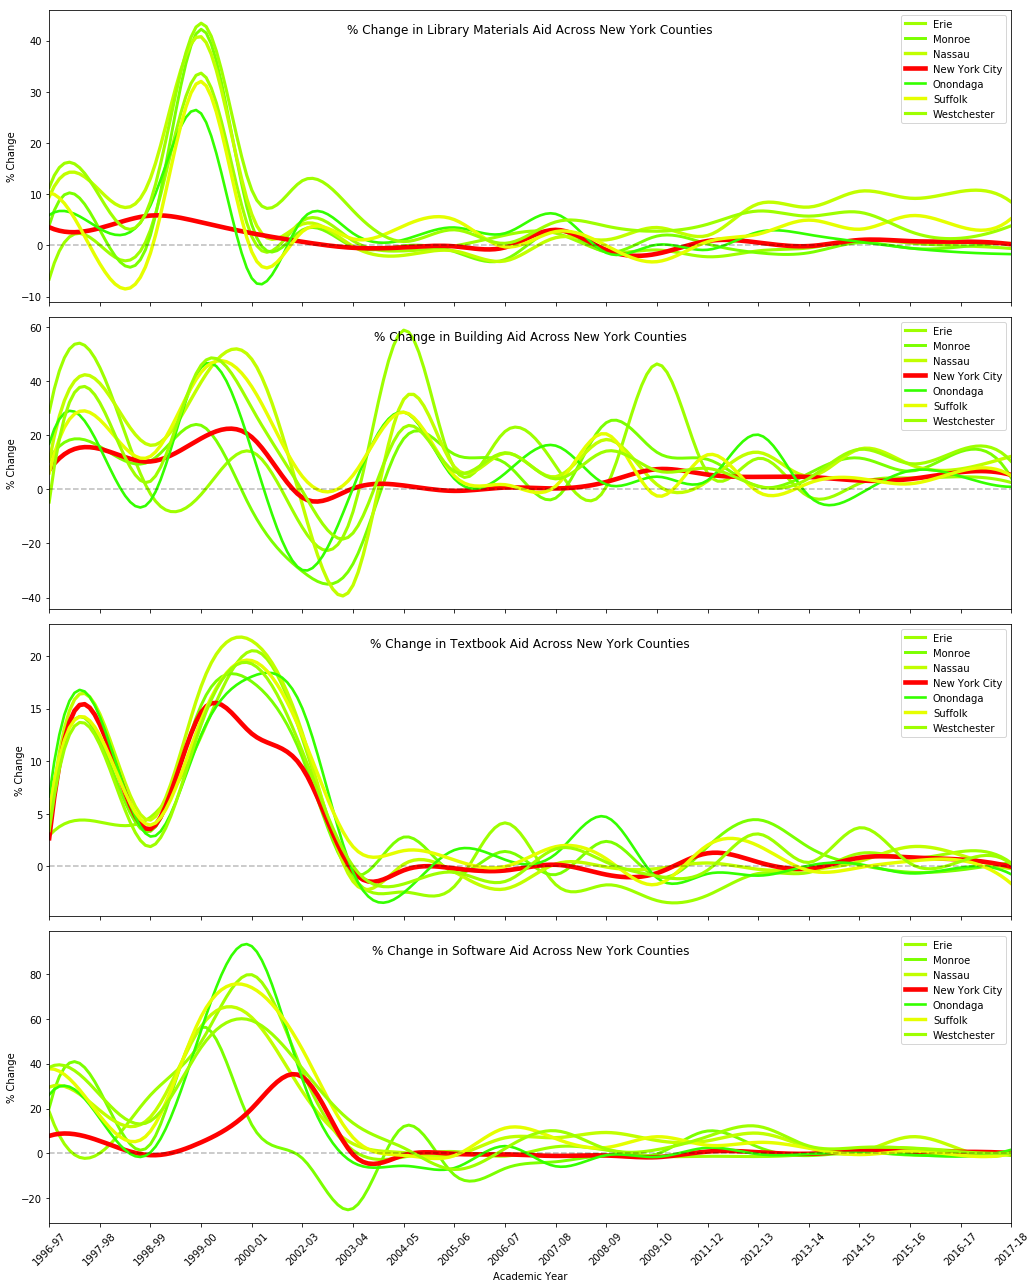

In [21]:
# Formatting and creating a visualization
graph_size = (14.5, 6*(3))
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=graph_size)

aids = ["Library Materials Aid", "Building Aid", "Textbook Aid", "Software Aid"]
ylims = [(-12, 50), (-50, 75), (-5, 25), (-35, 100)]
inctah = [0, 0, 0, 1]

# Set axis limits, labels, remove legends
for i in range(4):
    #axes[i].set_ylim(ymin=ylims[i][0], ymax=ylims[i][1])
    axes[i].set_xlim(xmin=0, xmax=19)
    axes[i].set_title("% Change in {} Across New York Counties".format(aids[i]), x=0.5, y=0.9)
    axes[i].set_ylabel("% Change")
    axes[i].set_xticks([i for i in range(0, 20)])
    
    res = create_multiindex_plot(aids[i], "Per Change", graph_size, ex_ax=axes[i])
    
    axes[i].axhline(y=0, linewidth=0.4, color="black", linestyle="dashed")
    
    if inctah[i] == 1:
        axes[i].set_xlabel("Academic Year")  
        axes[i].set_xticklabels(res.index.get_level_values(1), rotation=45)
    else:
        axes[i].tick_params(axis='x',labelbottom='off')

# Save to an SVG (Scalable Vector Graphics) file for online use
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.05)
fig.savefig("data.svg")